2025-04-28 22:14:52,418 - ModelEvaluation - INFO - --- Loading and Preparing Test Data ---
2025-04-28 22:14:52,453 - ModelEvaluation - INFO - Loaded raw data from C:\Users\seksc\Documents\SGH\sem6\licencjat\ML_classifications\ML\data\raw\heloc_dataset_v1.csv
2025-04-28 22:14:52,454 - src.features.build_features - INFO - Engineering new features...
2025-04-28 22:14:52,460 - src.features.build_features - WARNING - Skipping DTIxPercTradesWBalance interaction: required columns not found.
2025-04-28 22:14:52,461 - src.features.build_features - INFO - Creating indicator features for special values [-9, -8, -7] in columns: ['ExternalRiskEstimate', 'NumSatisfactoryTrades', 'NumTradesOpeninLast12M']
2025-04-28 22:14:52,468 - src.features.build_features - INFO - Feature engineering complete. New shape: (10459, 33)
2025-04-28 22:14:52,469 - src.features.build_features - INFO - Performing initial data preparation and type identification...
2025-04-28 22:14:52,471 - src.features.build_features - IN

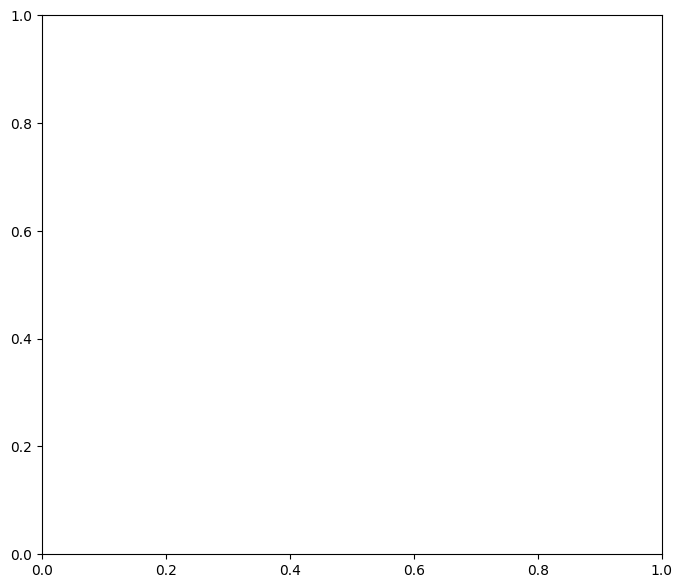

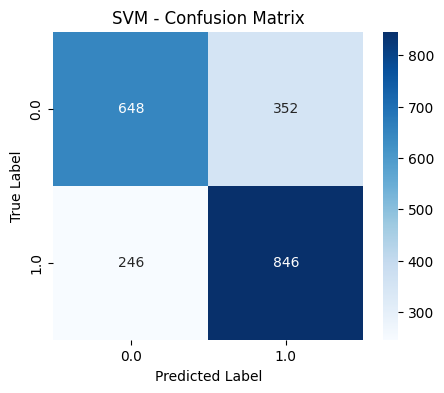

2025-04-28 22:14:54,605 - ModelEvaluation - INFO - 
--- Evaluating: XGBoost ---
2025-04-28 22:14:55,114 - ModelEvaluation - INFO - Loaded pipeline from C:\Users\seksc\Documents\SGH\sem6\licencjat\ML_classifications\ML\models\xgboost_tuned_pipeline.pkl
2025-04-28 22:14:55,140 - ModelEvaluation - INFO - ROC AUC: 0.7892
2025-04-28 22:14:55,169 - ModelEvaluation - INFO - Accuracy: 0.7185
2025-04-28 22:14:55,170 - ModelEvaluation - INFO - Precision (Class 1): 0.7163
2025-04-28 22:14:55,170 - ModelEvaluation - INFO - Recall (Class 1): 0.7628
2025-04-28 22:14:55,171 - ModelEvaluation - INFO - F1-Score (Class 1): 0.7388
2025-04-28 22:14:55,172 - ModelEvaluation - INFO - Confusion Matrix:
[[670 330]
 [259 833]]


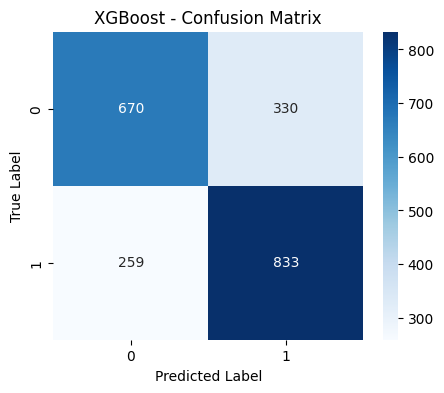

2025-04-28 22:14:55,321 - ModelEvaluation - INFO - 
--- Evaluating: PyTorch MLP ---
2025-04-28 22:14:55,333 - ModelEvaluation - ERROR - Failed to load pipeline C:\Users\seksc\Documents\SGH\sem6\licencjat\ML_classifications\ML\models\pytorch_mlp_tuned_pipeline.pkl: Can't get attribute 'Float32Transformer' on <module '__main__'>
Traceback (most recent call last):
  File "C:\Users\seksc\AppData\Local\Temp\ipykernel_35268\1606172884.py", line 98, in <module>
    pipeline = joblib.load(model_path)
  File "C:\Users\seksc\Documents\SGH\sem6\licencjat\.venv\lib\site-packages\joblib\numpy_pickle.py", line 658, in load
    obj = _unpickle(fobj, filename, mmap_mode)
  File "C:\Users\seksc\Documents\SGH\sem6\licencjat\.venv\lib\site-packages\joblib\numpy_pickle.py", line 577, in _unpickle
    obj = unpickler.load()
  File "C:\Users\seksc\AppData\Local\Programs\Python\Python310\lib\pickle.py", line 1213, in load
    dispatch[key[0]](self)
  File "C:\Users\seksc\AppData\Local\Programs\Python\Python3

In [2]:
# -*- coding: utf-8 -*-
# --- Imports ---
import logging
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import joblib # To load saved pipelines
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay # For plotting ROC curves
)

# --- Setup Paths and Configuration (adjust if notebook location differs) ---
# Assuming notebook is in notebooks/, navigate to project root
PROJECT_DIR = Path.cwd().parent # Go up one level from notebooks/
sys.path.append(str(PROJECT_DIR)) # Add project root to Python path

# Import project modules AFTER updating path
from src import config
from src.features import build_features
from src.models import utils # We need split_data for consistent test set

# --- Logging Setup (Optional but good practice) ---
logging.basicConfig(level=config.LOG_LEVEL, format=config.LOG_FORMAT, stream=sys.stdout)
logger = logging.getLogger("ModelEvaluation")

# --- Constants ---
MODELS_TO_EVALUATE = {
    "SVM": config.MODELS_DIR / "svm_tuned_pipeline.pkl",
    "XGBoost": config.MODELS_DIR / "xgboost_tuned_pipeline.pkl",
    "PyTorch MLP": config.MODELS_DIR / "pytorch_mlp_tuned_pipeline.pkl",
    # Add paths to other saved models if needed
}
POSITIVE_LABEL = config.POSITIVE_LABEL # Use the positive label from config

# --- 1. Load and Prepare Data (Replicate Training Preprocessing) ---
logger.info("--- Loading and Preparing Test Data ---")

# Load Raw Data
try:
    df_raw = pd.read_csv(config.RAW_DATA_PATH)
    logger.info(f"Loaded raw data from {config.RAW_DATA_PATH}")
except FileNotFoundError:
    logger.error(f"Raw data file not found at {config.RAW_DATA_PATH}. Cannot proceed.")
    # Stop execution in a notebook context (or raise error)
    raise SystemExit("Raw data file missing.")


# Engineer Features
df_engineered = build_features.engineer_features(df_raw)

# Preprocess Data (Identify types, handle target)
# Note: preprocess_data also returns positive_label, ensure it matches config
X, y, _, _, determined_positive_label = build_features.preprocess_data(df_engineered)
if determined_positive_label != POSITIVE_LABEL:
     logger.warning(f"Positive label determined during preprocessing ({determined_positive_label}) differs from config ({POSITIVE_LABEL}). Using determined label.")
     POSITIVE_LABEL = determined_positive_label # Use the one from data prep

# Split Data to get the *exact same* test set as used in training
# We need the original y for stratification, then use the processed y_test
_, X_test, _, y_test = utils.split_data(X, y) # y_test here is float32, shape (N, 1)

# Ensure y_test is 1D array of integers/floats for scikit-learn metrics
if y_test.ndim > 1 and y_test.shape[1] == 1:
    y_test_eval = y_test.ravel()
else:
    y_test_eval = y_test

logger.info(f"Test set shapes: X_test={X_test.shape}, y_test={y_test_eval.shape}")
logger.info(f"Test set target distribution:\n{pd.Series(y_test_eval).value_counts(normalize=True)}")


# --- 2. Load and Evaluate Models ---
logger.info("\n--- Loading and Evaluating Trained Models ---")

results = {} # Dictionary to store metrics
roc_plot_data = {} # To store data for combined ROC plot

fig_roc, ax_roc = plt.subplots(figsize=(8, 7)) # Create axes for combined ROC plot

for model_name, model_path in MODELS_TO_EVALUATE.items():
    logger.info(f"\n--- Evaluating: {model_name} ---")
    if not model_path.exists():
        logger.warning(f"Model file not found: {model_path}. Skipping.")
        continue

    # Load the pipeline
    try:
        pipeline = joblib.load(model_path)
        logger.info(f"Loaded pipeline from {model_path}")
    except Exception as e:
        logger.error(f"Failed to load pipeline {model_path}: {e}", exc_info=True)
        continue

    # Make predictions
    try:
        y_pred = pipeline.predict(X_test)
    except Exception as e:
        logger.error(f"Failed to predict using {model_name}: {e}", exc_info=True)
        continue

    # Make probability predictions (for ROC AUC)
    y_pred_proba = None
    roc_auc = None
    if hasattr(pipeline, "predict_proba"):
        try:
            # Get probabilities [prob_0, prob_1]
            proba_output = pipeline.predict_proba(X_test)
            # Assuming positive class is 1 and its prob is the second column
            if proba_output.ndim == 2 and proba_output.shape[1] >= 2:
                 positive_class_index = 1 # Default assumption
                 # Optional: Check pipeline.classes_ if available
                 if hasattr(pipeline, 'classes_'):
                      try:
                           classes_list = list(pipeline.classes_)
                           positive_class_index = classes_list.index(POSITIVE_LABEL)
                      except ValueError:
                           logger.warning(f"Positive label {POSITIVE_LABEL} not in pipeline classes {classes_list}. Using index 1.")

                 y_pred_proba = proba_output[:, positive_class_index]
                 roc_auc = roc_auc_score(y_test_eval, y_pred_proba)
                 logger.info(f"ROC AUC: {roc_auc:.4f}")
                 roc_plot_data[model_name] = {'y_true': y_test_eval, 'y_proba': y_pred_proba}
            else:
                 logger.warning(f"Predict_proba output shape unexpected: {proba_output.shape}. Cannot calculate ROC AUC reliably.")

        except Exception as e:
            logger.warning(f"Could not calculate ROC AUC for {model_name}. Error: {e}")
    else:
        logger.warning(f"Model {model_name} does not support predict_proba. Skipping ROC AUC.")

    # Calculate other metrics
    accuracy = accuracy_score(y_test_eval, y_pred)
    precision = precision_score(y_test_eval, y_pred, pos_label=POSITIVE_LABEL, zero_division=0)
    recall = recall_score(y_test_eval, y_pred, pos_label=POSITIVE_LABEL, zero_division=0)
    f1 = f1_score(y_test_eval, y_pred, pos_label=POSITIVE_LABEL, zero_division=0)
    cm = confusion_matrix(y_test_eval, y_pred)
    report = classification_report(y_test_eval, y_pred, zero_division=0)

    # Store results
    results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Confusion Matrix': cm,
        'Classification Report': report
    }

    # Print metrics
    logger.info(f"Accuracy: {accuracy:.4f}")
    logger.info(f"Precision (Class {POSITIVE_LABEL}): {precision:.4f}")
    logger.info(f"Recall (Class {POSITIVE_LABEL}): {recall:.4f}")
    logger.info(f"F1-Score (Class {POSITIVE_LABEL}): {f1:.4f}")
    logger.info(f"Confusion Matrix:\n{cm}")
    # logger.info(f"Classification Report:\n{report}") # Can be verbose

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=pipeline.classes_ if hasattr(pipeline, 'classes_') else ['Neg', 'Pos'],
                yticklabels=pipeline.classes_ if hasattr(pipeline, 'classes_') else ['Neg', 'Pos'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


# --- 3. Compare Models ---
logger.info("\n--- Model Comparison Summary ---")

# Display metrics in a DataFrame
metrics_to_show = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC']
summary_df = pd.DataFrame(results).T[metrics_to_show] # Transpose to get models as rows
print(summary_df.round(4))


# Plot combined ROC Curve
logger.info("\n--- Plotting Combined ROC Curves ---")
for model_name, data in roc_plot_data.items():
    try:
        RocCurveDisplay.from_predictions(
            data['y_true'],
            data['y_proba'],
            name=model_name,
            ax=ax_roc # Plot on the same axes
        )
    except Exception as e:
        logger.warning(f"Could not plot ROC curve for {model_name}: {e}")

ax_roc.plot([0, 1], [0, 1], 'k--', label='No Skill') # Add diagonal line
ax_roc.set_title('Receiver Operating Characteristic (ROC) Curves')
ax_roc.legend()
plt.show(fig_roc) # Show the combined plot

logger.info("\n--- Evaluation Complete ---")

